In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'])


In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_d = sales_d.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_d.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,96684,371027,879515
1,2019-02-01,99187,380632,902285
2,2019-03-01,113711,436369,1034407
3,2019-04-01,103982,399033,945904
4,2019-05-01,101826,390760,926291


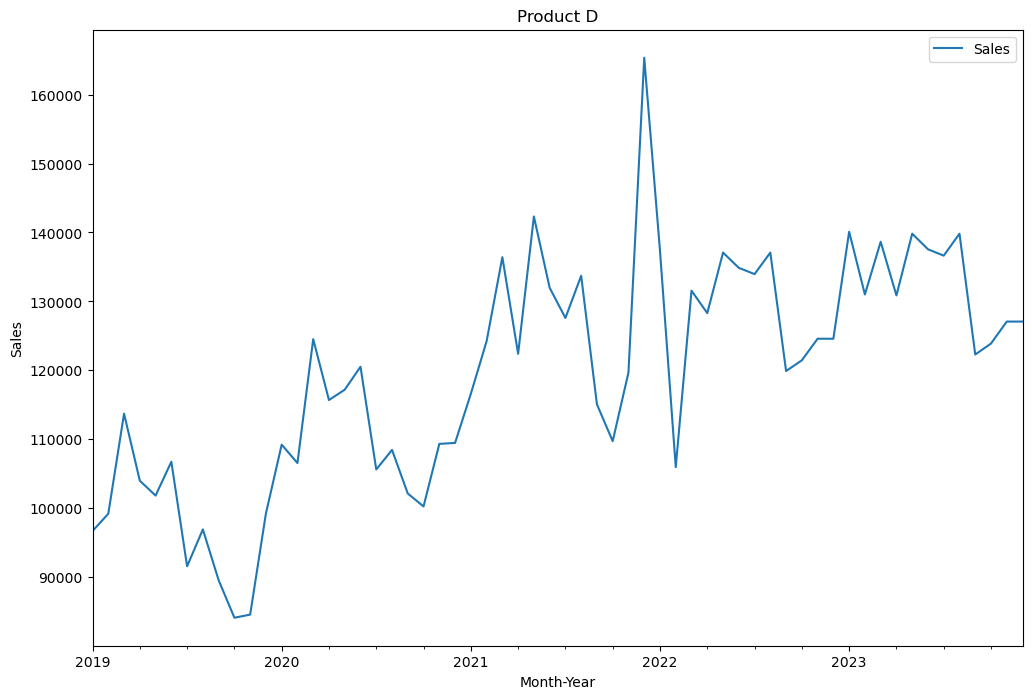

In [5]:
ax = sales_d.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product D')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_d[:48]
test=sales_d[48:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:40:15 - cmdstanpy - INFO - Chain [1] start processing
16:40:16 - cmdstanpy - INFO - Chain [1] done processing
16:40:20 - cmdstanpy - INFO - Chain [1] start processing
16:40:20 - cmdstanpy - INFO - Chain [1] done processing
16:40:23 - cmdstanpy - INFO - Chain [1] start processing
16:40:24 - cmdstanpy - INFO - Chain [1] done processing
16:40:27 - cmdstanpy - INFO - Chain [1] start processing
16:40:27 - cmdstanpy - INFO - Chain [1] done processing
16:40:30 - cmdstanpy - INFO - Chain [1] start processing
16:40:32 - cmdstanpy - INFO - Chain [1] done processing
16:40:36 - cmdstanpy - INFO - Chain [1] start processing
16:40:37 - cmdstanpy - INFO - Chain [1] done processing
16:40:40 - cmdstanpy - INFO - Chain [1] start processing
16:40:43 - cmdstanpy - INFO - Chain [1] done processing
16:40:46 - cmdstanpy - INFO - Chain [1] start processing
16:40:47 - cmdstanpy - INFO - Chain [1] done processing
16:40:50 - cmdstanpy - INFO - Chain [1] start processing
16:40:51 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0    12831.424962  
1    17484.627884  
2    17451.226057  
3    16001.866566  
4    18949.244176  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
12,0.010,0.01,additive,12612.500671
0,0.001,0.01,additive,12831.424962
25,0.100,0.01,multiplicative,13160.683471
24,0.100,0.01,additive,13399.619158
36,0.200,0.01,additive,14631.578620
...,...,...,...,...
57,0.300,5.00,multiplicative,53922.385822
65,0.500,1.00,multiplicative,92541.713075
69,0.500,5.00,multiplicative,92987.301296
71,0.500,10.00,multiplicative,94991.047053


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.010, seasonality_prior_scale=0.01, seasonality_mode = 'additive',interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

17:09:33 - cmdstanpy - INFO - Chain [1] start processing
17:09:33 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [13]:
future_dates['Market Size'] = sales_d['Market Size']
future_dates['Marketing Expense'] = sales_d['Marketing Expense']

In [14]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,371027,879515
1,2019-02-01,380632,902285
2,2019-03-01,436369,1034407
3,2019-04-01,399033,945904
4,2019-05-01,390760,926291
5,2019-06-01,409602,970956
6,2019-07-01,351390,832967
7,2019-08-01,371925,881644
8,2019-09-01,343654,814628
9,2019-10-01,324474,769162


In [15]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [16]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [17]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,147997.120414,133445.951373,161806.703922
49,2023-02-01,141352.074389,128091.257550,157220.468100
50,2023-03-01,151288.918256,135428.359014,166316.467151
51,2023-04-01,145278.087093,129951.601617,159631.211814
52,2023-05-01,152269.659069,139105.623101,167404.383654
53,2023-06-01,151649.107830,137905.468228,166590.869794
54,2023-07-01,148914.154773,133676.497140,162814.874814
55,2023-08-01,152618.129413,138517.346908,167798.116959
56,2023-09-01,141768.271125,126446.639043,156712.297935
57,2023-10-01,141224.429476,126051.240040,156978.333615


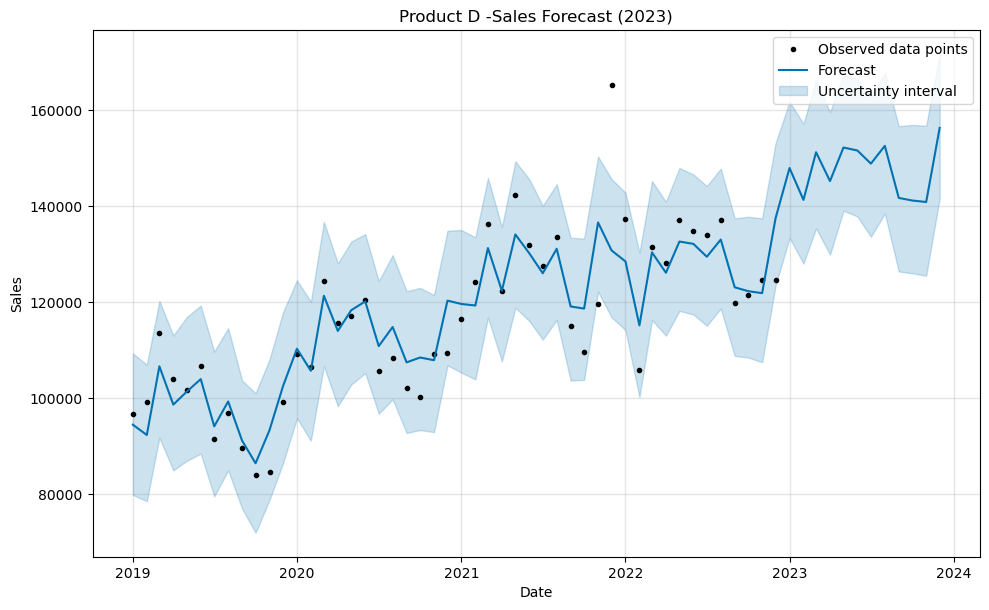

In [18]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product D -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

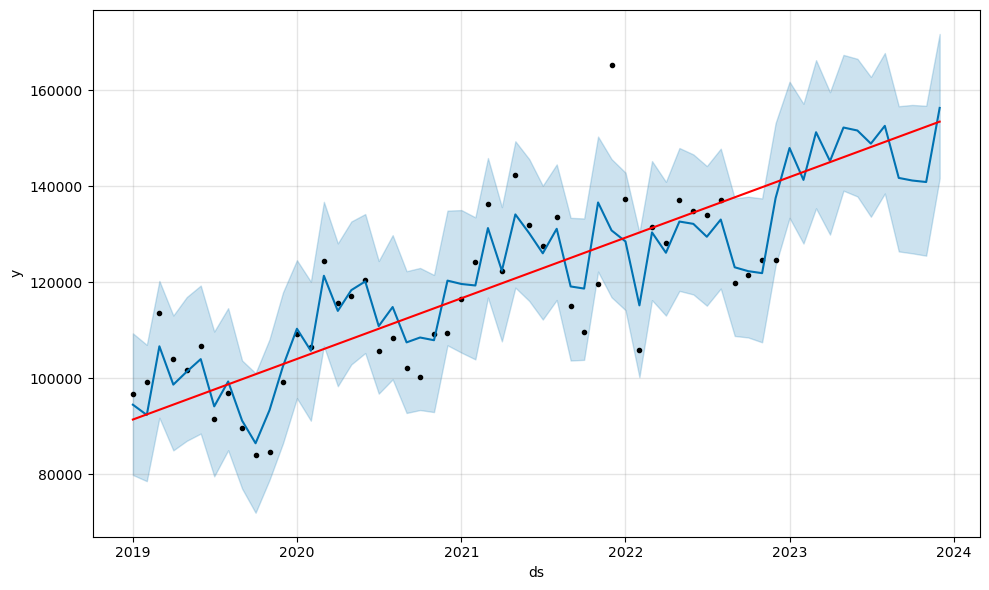

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

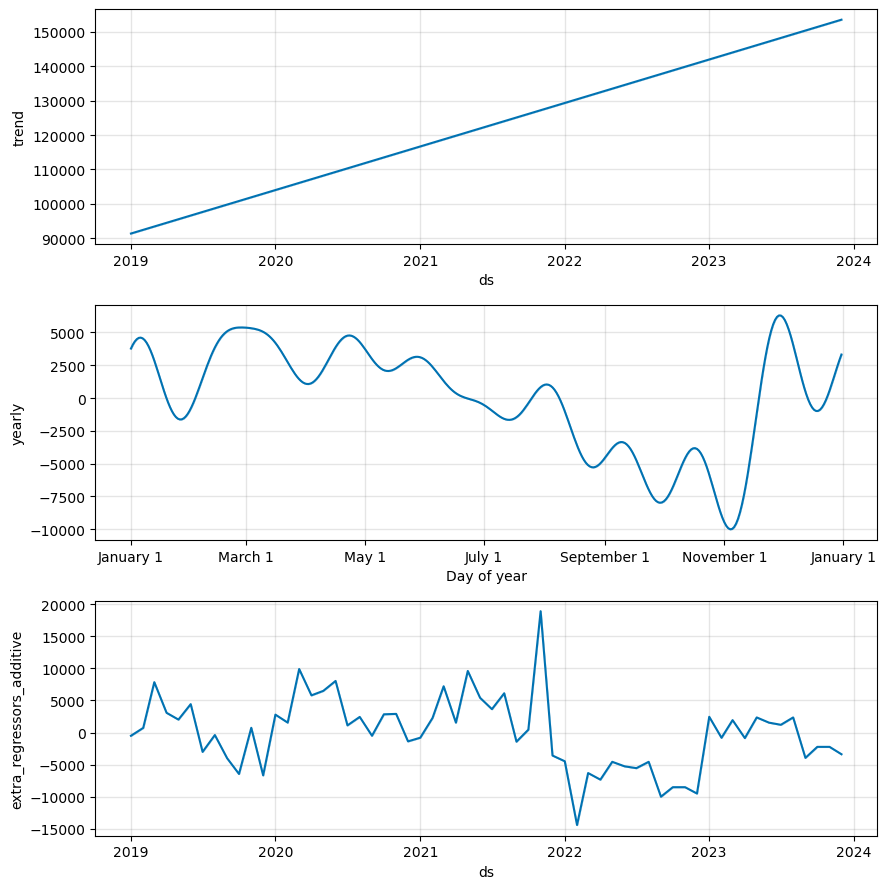

In [20]:
fig2 = model.plot_components(forecast)

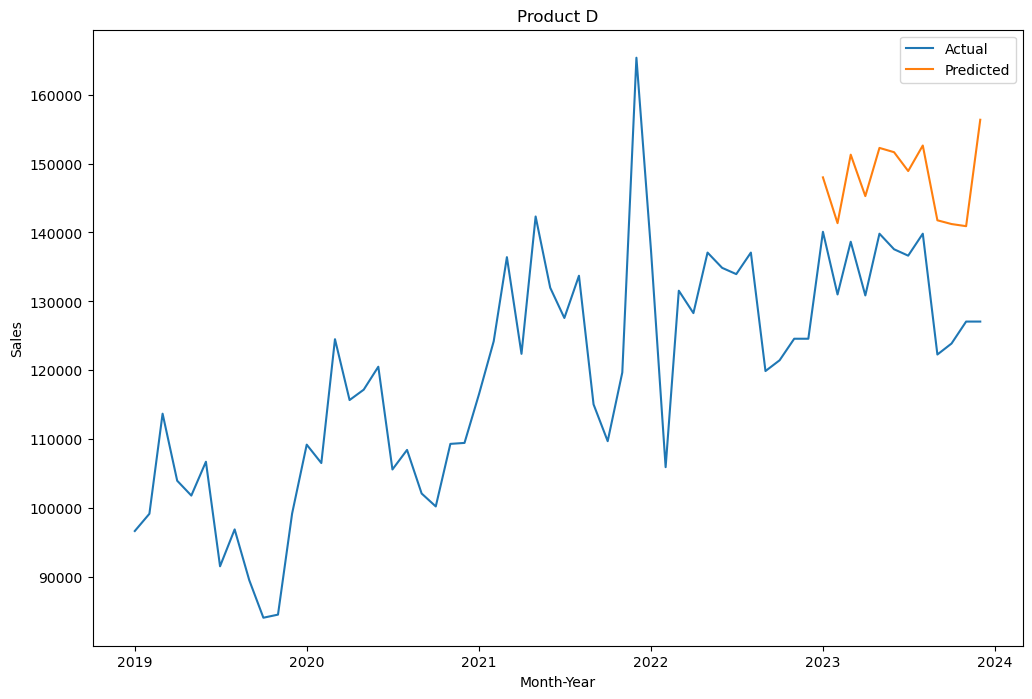

In [21]:
# Reset index of sales_b DataFrame
sales_d_reset_index = sales_d.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_d_reset_index['ds'], sales_d_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product D')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [22]:
#model evaluation

In [23]:
pred=forecasted_df['yhat']
test_df=test['y']

In [24]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 14735.012
MAPE - FB PROPHET: 0.112
MSE - FB PROPHET: 244430779.356
RMSE - FB PROPHET: 15634.282


In [25]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.069916e+08,10343.675349,10343.675349,0.075305,0.075305,0.078251,1.0
1,62 days,1.580669e+08,12572.464109,12572.464109,0.118666,0.118666,0.112020,1.0
2,90 days,2.298352e+05,479.411281,479.411281,0.003644,0.003644,0.003651,1.0
3,121 days,2.542782e+06,1594.610394,1594.610394,0.012429,0.012429,0.012506,1.0
4,151 days,1.967181e+07,4435.291042,4435.291042,0.032355,0.032355,0.032887,1.0
5,182 days,4.760020e+06,2181.746981,2181.746981,0.016177,0.016177,0.016309,1.0
6,212 days,2.008448e+07,4481.571055,4481.571055,0.033455,0.033455,0.034024,1.0
7,243 days,1.572263e+07,3965.176924,3965.176924,0.028925,0.028925,0.029350,1.0
8,274 days,2.634733e+07,5132.964854,5132.964854,0.042812,0.042812,0.041915,1.0
9,304 days,4.868517e+06,2206.471694,2206.471694,0.018167,0.018167,0.018003,1.0


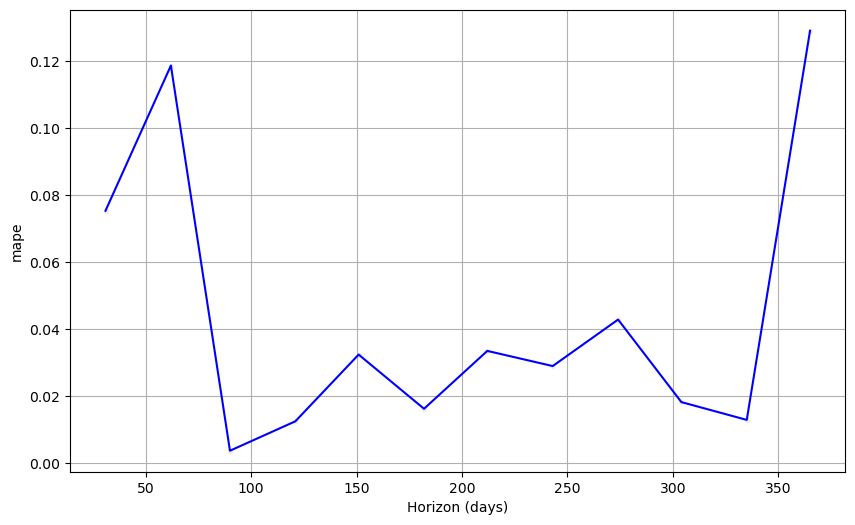

In [27]:
fig = plot_cross_validation_metric(df_cv, metric='mape')